# Import Packages

In [1]:
import xarray as xr
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
#from scipy import stats

import warnings
warnings.filterwarnings("ignore")

# Bias-Correction


In [68]:
def unzip(z_file, model):
    #Method to unzip the zipped file
    with zipfile.ZipFile(z_file, 'r') as zip_ref:
        zip_ref.extractall(model)
        #print('Done with '+model+' model')

        
def create_regrid_data(lon=[None, None], lat=[None, None], lon_gs=None, lat_gs=None):
    
    #check inputs
    if len(lon)!=2 or len(lat)!=2:
        raise SyntaxError("Enter the lon and lat as a list [], containing the minimum and maximum values respectively.")
    
    #if len(lon_gs)<1:
    #    raise SyntaxError("Enter the grid interval")
    
    lon = np.arange(lon[0], lon[1]+lon_gs, lon_gs)
    lat = np.arange(lat[0], lat[1]+lat_gs, lat_gs)
    coords = np.meshgrid(lat,lon)
    A = np.ones(np.shape(coords))*np.nan
    
    regrid_mask = xr.DataArray(data = A[0], dims = ('lon','lat'), coords={'lon':lon, 'lat':lat})

    return regrid_mask


def bias_correction(observed_data, model_data, method='QM'):
    if method == 'QM':
        # Quantile Mapping
        # Calculate the mapping between observed and model data quantiles
        observed_quantiles = np.nanpercentile(observed_data, q=np.arange(0, 101))
        model_quantiles = np.nanpercentile(model_data, q=np.arange(0, 101))

        # Map the model data to observed data quantiles
        corrected_data = np.interp(model_data, model_quantiles, observed_quantiles)
        
    elif method == 'SC':
        # Calculate the mean and standard deviation of observed and model data
        observed_mean = np.nanmean(observed_data)
        model_mean = np.nanmean(model_data)
        observed_std = np.nanstd(observed_data)
        model_std = np.nanstd(model_data)

        # Scale the model data by matching the mean and standard deviation of observed data
        corrected_data = ((model_data - model_mean) * (observed_std / model_std)) + observed_mean

    
    return corrected_data


def bias(x, y):
    return x.sum() - y.sum()

# Read The Data

In [4]:
datasets = ['access_cm2','awi-esm-1-1-lr','bcc_csm2_mr','cmcc_cm2_hr4','cmcc_cm2_sr5','cmcc_esm2','cnrm_cm6_1_hr','cnrm_cm6_1','cnrm_esm2_1','ec_earth3_veg_lr',
          'fgoals-f3-l', 'gfdl_esm4','hadgem3_gc31_ll','hadgem3_gc31_mm','inm_cm4_8','inm_cm5_0','ipsl_cm6a_lr','kace_1_0_g','kiost_esm','miroc6','mpi_esm1_2_hr','mpi_esm1_2_lr',
            'mri_esm2_0','nesm3','noresm2_mm','sam0_unicon','taiesm1','ukesm1_0_ll']


In [86]:
%%time

DF_Data = xr.Dataset()
cmip_dir = 'CMIP6_data'
zipped_cmip_dir = 'Dataset/historical'


p = create_regrid_data(lon=[-25, 25], lat=[0, 25], lon_gs=0.5, lat_gs=0.5)

#chirps = xr.open_mfdataset('data/chirps*.nc')['precip'].interp_like(p)


for d_id, data in enumerate(datasets[:]):
    try:
        data_file = glob.glob(os.path.join(os.getcwd(),'{}/pr_day_{}*.nc'.format(cmip_dir,data.upper().replace('_','-'))))[-1]
    except:
        unzip(glob.glob(os.path.join(os.getcwd(),'{zipped_cmip_dir}/cmip6_download_*{data}*.zip'))[0], data)
        data_file = glob.glob(os.path.join(os.getcwd(),data+'/pr*.nc'))[-1]
    Data = (xr.open_dataset(data_file).pr * 86400)/1   #convert rainfall from kg m-2 s-1 to mm/day

    if Data.lon.max()>200:
        Data.coords['lon'] = (Data.coords['lon'] + 180) % 360 - 180
        Data = Data.sortby(Data.lon)

    try:
        Data['time'] = Data['time'].astype("datetime64[ns]")
        DF_Data[data] = Data.interp_like(p)
        #.name('precip')
        
    except:
        pass

CPU times: total: 1min 8s
Wall time: 2min 31s


# Apply Bias-Correction Technique

***Let's Assume The Ensemble Mean As The Reference Data For Now***


In [94]:
variables = list(DF_Data.var())
# Compute The Ensemble Mean
#DF_Data['ensemble_mean'] = DF_Data.to_array(dim='variable').reduce(np.nanmean, 'variable')

In [ ]:
%%time
#reference_data = DF_Data['ensemble_mean']
reference_data = chirps


bc_corrected_data = xr.Dataset()
for data in variables:
    var_name = 'precip'
    cor_data = bias_correction(reference_data.values, DF_Data[data].values, method='QM')
    bc_corrected_data[data] = xr.DataArray(cor_data, dims=DF_Data[data].dims, coords=DF_Data[data].coords)
    

In [ ]:
out_file = '..... '
bc_corrected_data.to_netcdf(out_file)

# End of Bias Correction

# Visualization

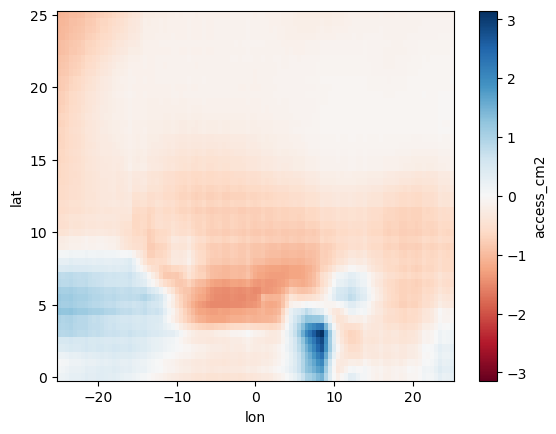

In [101]:
(DF_Data.access_cm2 - bc_corrected_data.access_cm2).mean('time').plot(cmap='RdBu')

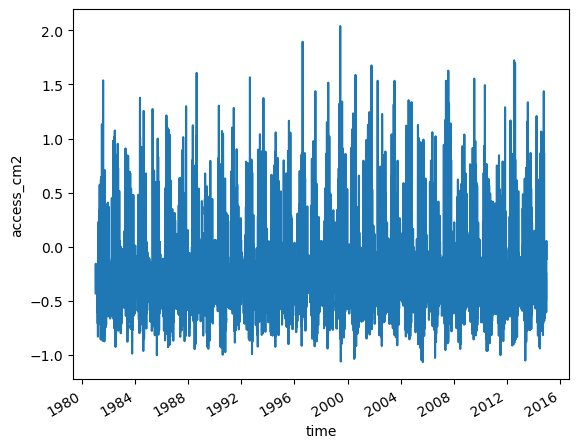

In [103]:
(DF_Data.access_cm2 - bc_corrected_data.access_cm2).mean(['lon','lat']).plot()

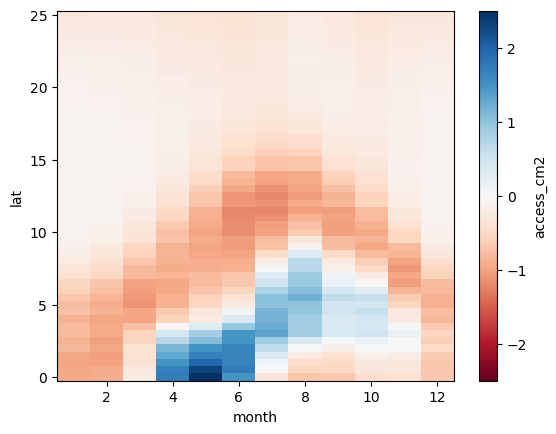

In [105]:
(DF_Data.access_cm2 - bc_corrected_data.access_cm2).groupby('time.month').mean(['time','lon']).plot(cmap='RdBu', y='lat')

In [ ]:
# Apply quantile mapping bias correction
cor_data = bias_correction(DF_Data.ensemble_mean.values, DF_Data.access_cm2.values, method='QM')
SM_cor_data = bias_correction(DF_Data.ensemble_mean.values, DF_Data.access_cm2.values, method='SC')

# Create a new xarray DataArray with the corrected data and the same dimensions and coordinates
cor_data = xr.DataArray(cor_data, dims=DF_Data.access_cm2.dims, coords=DF_Data.access_cm2.coords)
SM_cor_data = xr.DataArray(SM_cor_data, dims=DF_Data.access_cm2.dims, coords=DF_Data.access_cm2.coords)


In [ ]:




fig, axes = plt.subplots(ncols=2, nrows=2,  figsize=(8,3))

ax = axes[0,0]
cor_data.mean(['lat','lon']).plot(ax = ax)
DF_Data.ensemble_mean.mean(['lat','lon']).plot(ax = ax)
DF_Data.access_cm2.mean(['lat','lon']).plot(ax = ax)

ax = axes[0,1]
#r1 = np.corrcoef(DF_Data.ensemble_mean.mean(['lat','lon']).values, DF_Data.access_cm2.mean(['lat','lon']).values)[0,1]
#r2 = np.corrcoef(DF_Data.ensemble_mean.mean(['lat','lon']).values, cor_data.mean(['lat','lon']).values)[0,1]

r1 = bias(DF_Data.ensemble_mean.mean(['lat','lon']).values, DF_Data.access_cm2.mean(['lat','lon']).values)
r2 = bias(DF_Data.ensemble_mean.mean(['lat','lon']).values, cor_data.mean(['lat','lon']).values)

ax.plot(DF_Data.ensemble_mean.mean(['lat','lon']).values, DF_Data.access_cm2.mean(['lat','lon']).values, 'go', markersize=2, label=str(round(r1,2)))
ax.plot(DF_Data.ensemble_mean.mean(['lat','lon']).values, cor_data.mean(['lat','lon']).values, 'ro', markersize=2, label=str(round(r2,2)))
ax.plot(np.arange(10),np.arange(10), 'k--')
ax.legend()



# Scaling Approach
ax = axes[1,0]
SM_cor_data.mean(['lat','lon']).plot(ax = ax)
DF_Data.ensemble_mean.mean(['lat','lon']).plot(ax = ax)
DF_Data.access_cm2.mean(['lat','lon']).plot(ax = ax)

ax = axes[1,1]
#r1 = np.corrcoef(DF_Data.ensemble_mean.mean(['lat','lon']).values, DF_Data.access_cm2.mean(['lat','lon']).values)[0,1]
#r2 = np.corrcoef(DF_Data.ensemble_mean.mean(['lat','lon']).values, SM_cor_data.mean(['lat','lon']).values)[0,1]

r1 = bias(DF_Data.ensemble_mean.mean(['lat','lon']).values, DF_Data.access_cm2.mean(['lat','lon']).values)
r2 = bias(DF_Data.ensemble_mean.mean(['lat','lon']).values, SM_cor_data.mean(['lat','lon']).values)


ax.plot(DF_Data.ensemble_mean.mean(['lat','lon']).values, DF_Data.access_cm2.mean(['lat','lon']).values, 'go', markersize=2, label=str(round(r1,2)))
ax.plot(DF_Data.ensemble_mean.mean(['lat','lon']).values, SM_cor_data.mean(['lat','lon']).values, 'ro', markersize=2, label=str(round(r2,2)))
ax.plot(np.arange(10),np.arange(10), 'k--')
ax.legend()
